# **a.** SMILES Analysis

The first challenge in predicting penetration is that SMILES notation does not provide any information about the 3D structure of the molecule, which can be crucial. The second challenge is that SMILES natation miss some information; it means that different SMILES strings can represents the same molecule [(more information)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2523-5).

These two plots shows each smiles has 12 unique tokens and 50 total charachters approximately. Also, we can see that the most frequent character is C that makes sense as it plays a critical role in our lifes. The second character is () that means branch.

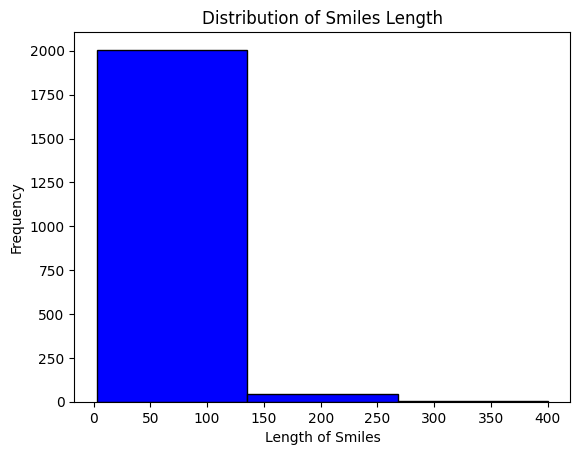

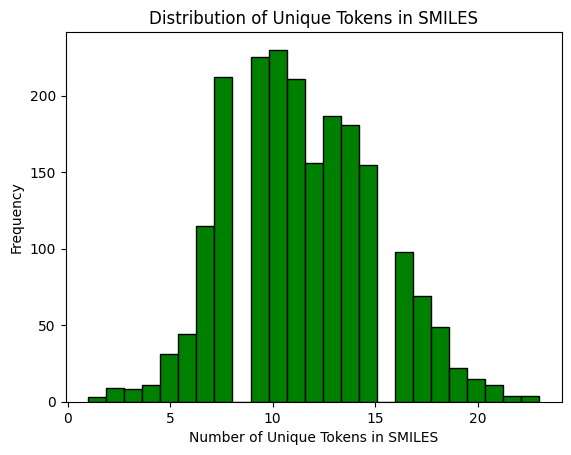

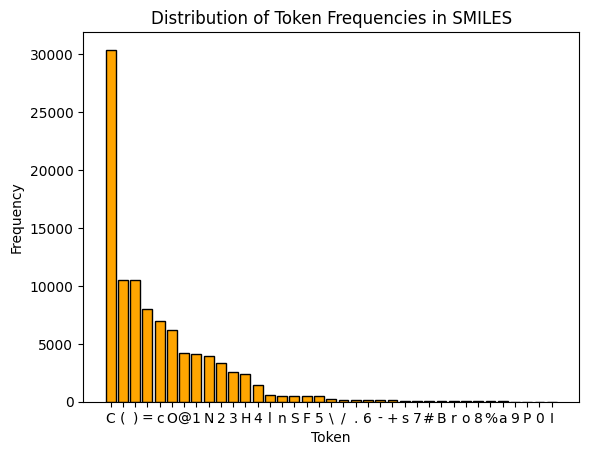

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('BBBP.csv')

# Calculate the length of each 'smiles' entry and create a new column 'smiles_length'
df['smiles_length'] = df['smiles'].apply(len)
df['unique_tokens'] = df['smiles'].apply(lambda x: len(set(x)))
all_tokens = ''.join(df['smiles']).replace('[', '').replace(']', '').replace(',', '').replace("'", "")
token_counts = pd.Series(list(all_tokens)).value_counts()


# Plot the distribution of 'smiles_length'
plt.hist(df['smiles_length'], bins=3, color='blue', edgecolor='black')
plt.xlabel('Length of Smiles')
plt.ylabel('Frequency')
plt.title('Distribution of Smiles Length')
plt.show()


plt.figure()
# Plot the distribution of unique tokens
plt.hist(df['unique_tokens'], bins=25, color='green', edgecolor='black')
plt.xlabel('Number of Unique Tokens in SMILES')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Tokens in SMILES')
plt.show()

plt.figure()
# Plot the distribution of token frequencies
plt.bar(token_counts.index, token_counts.values, color='orange', edgecolor='black')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Distribution of Token Frequencies in SMILES')
plt.show()
# 76.83

# b. Baseline

we get 0.7905 auc with a fc. As the classes distribution is not balance, we used area under curve to analysis the model.

In [ ]:
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('BBBP.csv')

# Get all unique characters in the SMILES column
unique_characters = set(''.join(df['smiles'])) #39

# Create a dictionary mapping each unique character to its index
char_to_index = {char: i for i, char in enumerate(unique_characters)}

# Function to create one-hot vector for a single character
def char_to_one_hot(char):
    vector = np.zeros(len(unique_characters))
    vector[char_to_index[char]] = 1
    return vector

# Function to create one-hot vector for a SMILES string
def smiles_to_one_hot(smiles):
    return np.concatenate([char_to_one_hot(char) for char in smiles])

# Apply the one-hot encoding to the 'smiles' column
df['smiles_one_hot'] = df['smiles'].apply(smiles_to_one_hot)

# Convert the 'smiles_one_hot' column to a NumPy array
one_hot_array = np.array(df['smiles_one_hot'].to_list())

# Step 1: Find the maximum length of vectors
max_length = max(len(vector) for vector in one_hot_array)

# Step 2: Zero-pad each vector to the maximum length
padded_vectors = [np.pad(vector, (0, max_length - len(vector)), 'constant') for vector in one_hot_array]

# Step 3: Convert the list of vectors to a 2D NumPy array (matrix)
one_hot_array = np.array(padded_vectors) #39*400,2050

<ipython-input-15-c78c3c945a73>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  one_hot_array = np.array(df['smiles_one_hot'].to_list())


[0. 0. 0. ... 0. 0. 0.]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


# Extract labels from the 'p_np' column
labels = df['p_np'].values

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(one_hot_array)
y_tensor = torch.FloatTensor(labels)

# Define cross-validation
num_splits = 5
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)


# Initialize a list to store AUC scores for each fold
auc_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X_tensor, y_tensor)):
    X_train_fold, X_test_fold = X_tensor[train_index], X_tensor[test_index]
    y_train_fold, y_test_fold = y_tensor[train_index], y_tensor[test_index]

    # Instantiate the model for each fold
    input_size = one_hot_array.shape[1]
    hidden_size1 = 2048
    hidden_size2 = 128
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    model = SimpleNN(input_size, hidden_size1, hidden_size2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_fold)
        loss = criterion(outputs, y_train_fold.view(-1, 1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training loss for every epoch (optional)
        print(f'Fold [{fold + 1}/{num_splits}], Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model on the test set for each fold
    with torch.no_grad():
        test_outputs = model(X_test_fold)
        test_loss = criterion(test_outputs, y_test_fold.view(-1, 1))
        predictions = (test_outputs > 0.5).float()
        auc_score = roc_auc_score(y_test_fold.numpy(), predictions.numpy())
        auc_scores.append(auc_score)
        print(f'Fold [{fold + 1}/{num_splits}], Test AUC: {auc_score:.4f}')

# Print the average AUC score over all folds
average_auc = sum(auc_scores) / num_splits
print(f'Average AUC over {num_splits} folds: {average_auc:.4f}')

Fold [1/5], Epoch [1/10], Loss: 0.6802
Fold [1/5], Epoch [2/10], Loss: 0.6294
Fold [1/5], Epoch [3/10], Loss: 0.5550
Fold [1/5], Epoch [4/10], Loss: 0.4814
Fold [1/5], Epoch [5/10], Loss: 0.4286
Fold [1/5], Epoch [6/10], Loss: 0.3862
Fold [1/5], Epoch [7/10], Loss: 0.3402
Fold [1/5], Epoch [8/10], Loss: 0.3019
Fold [1/5], Epoch [9/10], Loss: 0.2721
Fold [1/5], Epoch [10/10], Loss: 0.2456
Fold [1/5], Test AUC: 0.7747
Fold [2/5], Epoch [1/10], Loss: 0.6893
Fold [2/5], Epoch [2/10], Loss: 0.6230
Fold [2/5], Epoch [3/10], Loss: 0.5393
Fold [2/5], Epoch [4/10], Loss: 0.4677
Fold [2/5], Epoch [5/10], Loss: 0.4200
Fold [2/5], Epoch [6/10], Loss: 0.3757
Fold [2/5], Epoch [7/10], Loss: 0.3317
Fold [2/5], Epoch [8/10], Loss: 0.2995
Fold [2/5], Epoch [9/10], Loss: 0.2736
Fold [2/5], Epoch [10/10], Loss: 0.2481
Fold [2/5], Test AUC: 0.8080
Fold [3/5], Epoch [1/10], Loss: 0.6821
Fold [3/5], Epoch [2/10], Loss: 0.6358
Fold [3/5], Epoch [3/10], Loss: 0.5669
Fold [3/5], Epoch [4/10], Loss: 0.4959
Fold

# c. LSTM

we get 0.8242 auc with lstm. The results improved 0.0334

In [ ]:
# Define the model with an LSTM layer followed by a fully connected layer
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
input_size = one_hot_array.shape[1]
hidden_size1 = 64
hidden_size2 = 32
model = LSTMModel(input_size, hidden_size1, hidden_size2)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.015)


# Set seed for reproducibility
torch.manual_seed(42)

# Assuming one_hot_array and labels are already defined
# Convert labels to float tensor
labels_tensor = torch.FloatTensor(labels).view(-1, 1)

# Set the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a list to store AUC scores for each fold
auc_scores = []

# Loop over folds
for fold, (train_index, test_index) in enumerate(skf.split(one_hot_array, labels)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split data into training and validation sets
    X_train_fold, X_val_fold = one_hot_array[train_index], one_hot_array[test_index]
    y_train_fold, y_val_fold = labels_tensor[train_index], labels_tensor[test_index]

    # Convert data to PyTorch tensors
    X_train_tensor_fold = torch.FloatTensor(X_train_fold)
    y_train_tensor_fold = torch.FloatTensor(y_train_fold)
    X_val_tensor_fold = torch.FloatTensor(X_val_fold)
    y_val_tensor_fold = torch.FloatTensor(y_val_fold)

    # Instantiate the model for each fold
    model = LSTMModel(input_size, hidden_size1, hidden_size2)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.018)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor_fold)
        loss = criterion(outputs, y_train_tensor_fold)
        loss.backward()
        optimizer.step()

        # Print training loss for every epoch
        print(f'Fold [{fold + 1}/{num_folds}], Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor_fold)
        val_loss = criterion(val_outputs, y_val_tensor_fold.view(-1, 1))
        val_predictions = (val_outputs > 0.5).float()
        val_auc_score = roc_auc_score(y_val_tensor_fold.numpy(), val_predictions.numpy())
        auc_scores.append(val_auc_score)

        print(f'Fold [{fold + 1}/{num_folds}], Validation AUC: {val_auc_score:.4f}')

# Print average AUC score across all folds
average_auc = sum(auc_scores) / num_folds
print(f'Average AUC Score: {average_auc:.4f}')

Fold 1/5
Fold [1/5], Epoch [1/10], Loss: 0.7080
Fold [1/5], Epoch [2/10], Loss: 0.5469
Fold [1/5], Epoch [3/10], Loss: 0.4369
Fold [1/5], Epoch [4/10], Loss: 0.2816
Fold [1/5], Epoch [5/10], Loss: 0.3197
Fold [1/5], Epoch [6/10], Loss: 0.2009
Fold [1/5], Epoch [7/10], Loss: 0.2055
Fold [1/5], Epoch [8/10], Loss: 0.1655
Fold [1/5], Epoch [9/10], Loss: 0.1429
Fold [1/5], Epoch [10/10], Loss: 0.1321
Fold [1/5], Validation AUC: 0.8637
Fold 2/5
Fold [2/5], Epoch [1/10], Loss: 0.7194
Fold [2/5], Epoch [2/10], Loss: 0.5620
Fold [2/5], Epoch [3/10], Loss: 0.4293
Fold [2/5], Epoch [4/10], Loss: 0.3098
Fold [2/5], Epoch [5/10], Loss: 0.2080
Fold [2/5], Epoch [6/10], Loss: 0.1602
Fold [2/5], Epoch [7/10], Loss: 0.1536
Fold [2/5], Epoch [8/10], Loss: 0.1215
Fold [2/5], Epoch [9/10], Loss: 0.0882
Fold [2/5], Epoch [10/10], Loss: 0.0740
Fold [2/5], Validation AUC: 0.7807
Fold 3/5
Fold [3/5], Epoch [1/10], Loss: 0.6818
Fold [3/5], Epoch [2/10], Loss: 0.4942
Fold [3/5], Epoch [3/10], Loss: 0.3398
Fold

# d. BiLSTM

we get 0.8475 auc with bilstm. The results improved 0.0567 compared to baseline.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=True)
        # For bidirectional LSTM, the output size is doubled
        self.fc1 = nn.Linear(hidden_size1 * 2, hidden_size2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the BiLSTM model
input_size = one_hot_array.shape[1]
hidden_size1 = 64
hidden_size2 = 32




# Set seed for reproducibility
torch.manual_seed(42)

# Assuming one_hot_array and labels are already defined
labels_tensor = torch.FloatTensor(labels).view(-1, 1)

# Set the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a list to store AUC scores for each fold
auc_scores = []

# Loop over folds
for fold, (train_index, test_index) in enumerate(skf.split(one_hot_array, labels)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split data into training and validation sets
    X_train_fold, X_val_fold = one_hot_array[train_index], one_hot_array[test_index]
    y_train_fold, y_val_fold = labels_tensor[train_index], labels_tensor[test_index]

    # Convert data to PyTorch tensors
    X_train_tensor_fold = torch.FloatTensor(X_train_fold)
    y_train_tensor_fold = torch.FloatTensor(y_train_fold)
    X_val_tensor_fold = torch.FloatTensor(X_val_fold)
    y_val_tensor_fold = torch.FloatTensor(y_val_fold)

    # Instantiate the model for each fold
    model = BiLSTMModel(input_size, hidden_size1, hidden_size2)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.010)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor_fold)
        loss = criterion(outputs, y_train_tensor_fold)
        loss.backward()
        optimizer.step()

        # Print training loss for every epoch
        print(f'Fold [{fold + 1}/{num_folds}], Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor_fold)
        val_loss = criterion(val_outputs, y_val_tensor_fold.view(-1, 1))
        val_predictions = (val_outputs > 0.5).float()
        val_auc_score = roc_auc_score(y_val_tensor_fold.numpy(), val_predictions.numpy())
        auc_scores.append(val_auc_score)

        print(f'Fold [{fold + 1}/{num_folds}], Validation AUC: {val_auc_score:.4f}')

# Print average AUC score across all folds
average_auc = sum(auc_scores) / num_folds
print(f'Average AUC Score: {average_auc:.4f}')

Fold 1/5
Fold [1/5], Epoch [1/10], Loss: 0.7050
Fold [1/5], Epoch [2/10], Loss: 0.5635
Fold [1/5], Epoch [3/10], Loss: 0.4420
Fold [1/5], Epoch [4/10], Loss: 0.2924
Fold [1/5], Epoch [5/10], Loss: 0.2930
Fold [1/5], Epoch [6/10], Loss: 0.1794
Fold [1/5], Epoch [7/10], Loss: 0.2088
Fold [1/5], Epoch [8/10], Loss: 0.1398
Fold [1/5], Epoch [9/10], Loss: 0.1340
Fold [1/5], Epoch [10/10], Loss: 0.1274
Fold [1/5], Validation AUC: 0.8708
Fold 2/5
Fold [2/5], Epoch [1/10], Loss: 0.6792
Fold [2/5], Epoch [2/10], Loss: 0.5361
Fold [2/5], Epoch [3/10], Loss: 0.4281
Fold [2/5], Epoch [4/10], Loss: 0.2840
Fold [2/5], Epoch [5/10], Loss: 0.2499
Fold [2/5], Epoch [6/10], Loss: 0.1674
Fold [2/5], Epoch [7/10], Loss: 0.1746
Fold [2/5], Epoch [8/10], Loss: 0.1165
Fold [2/5], Epoch [9/10], Loss: 0.1110
Fold [2/5], Epoch [10/10], Loss: 0.0847
Fold [2/5], Validation AUC: 0.8119
Fold 3/5
Fold [3/5], Epoch [1/10], Loss: 0.7338
Fold [3/5], Epoch [2/10], Loss: 0.5874
Fold [3/5], Epoch [3/10], Loss: 0.4802
Fold

# e. Per Bins!

1. fc bins

<ipython-input-70-5a3862db7c69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels, dtype=torch.float32)
Folds: 5it [00:34,  6.99s/it]


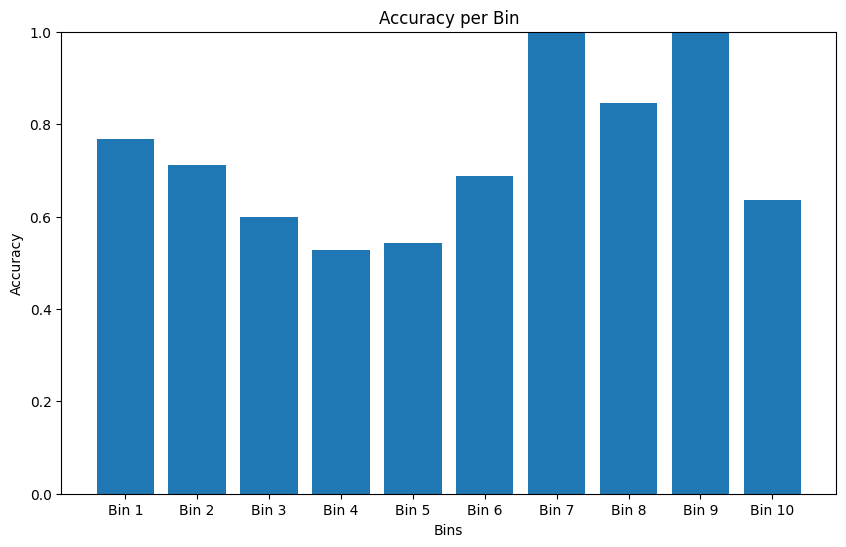

Total Accuracy: 0.7080
[0.7683883159977977, 0.7116173689656403, 0.5980204162201793, 0.5284044577330796, 0.5427769985974754, 0.6884057971014492, 1.0, 0.8461538461538461, 1.0, 0.6363636363636364]


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants
NUM_BINS = 10
N_SPLITS = 5
BATCH_SIZE = 64
N_EPOCHS = 10
THRESHOLD = 0.5
RANDOM_STATE = 42
LEARNING_RATE = 0.001
HIDDEN_SIZE1 = 64
HIDDEN_SIZE2 = 32

# Initialize metrics storage
auc_scores_per_bin = [[] for _ in range(NUM_BINS)]
TP_counts_per_bin = [0] * NUM_BINS
TN_counts_per_bin = [0] * NUM_BINS
FP_counts_per_bin = [0] * NUM_BINS
FN_counts_per_bin = [0] * NUM_BINS

# Cross-validation setup
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Convert features and labels to PyTorch tensors
features_tensor = torch.tensor(one_hot_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

for fold, (train_idx, test_idx) in enumerate(tqdm(kfold.split(features_tensor, labels_tensor), desc="Folds")):
    # Data preparation
    train_features, test_features = features_tensor[train_idx], features_tensor[test_idx]
    train_labels, test_labels = labels_tensor[train_idx], labels_tensor[test_idx]
    train_labels, test_labels = train_labels.unsqueeze(1), test_labels.unsqueeze(1)

    # Datasets and loaders
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Model initialization
    model = SimpleNN(train_features.shape[1], HIDDEN_SIZE1, HIDDEN_SIZE2)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    for epoch in range(N_EPOCHS):
        model.train()
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_features)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()

    # Model evaluation
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_predictions = model(batch_features)
            test_predictions.extend(batch_predictions.numpy())

    # Metrics calculation
    auc_score = roc_auc_score(test_labels, np.array(test_predictions))
    bin_indices = pd.cut(df.iloc[test_idx]['smiles_length'], bins=NUM_BINS, labels=False)

    for bin_idx in range(NUM_BINS):
        bin_mask = (bin_indices == bin_idx)
        if bin_mask.any():
            auc_scores_per_bin[bin_idx].append(auc_score)


    # TP, TN, FP, FN counts
    for bin_idx in range(NUM_BINS):
        bin_mask = (bin_indices == bin_idx)
        bin_predictions = (np.array(test_predictions)[bin_mask] > THRESHOLD).astype(int)
        bin_labels = np.array(test_labels)[bin_mask].squeeze()

        TP = np.sum((bin_predictions == 1) & (bin_labels == 1))
        TN = np.sum((bin_predictions == 0) & (bin_labels == 0))
        FP = np.sum((bin_predictions == 1) & (bin_labels == 0))
        FN = np.sum((bin_predictions == 0) & (bin_labels == 1))

        TP_counts_per_bin[bin_idx] += TP
        TN_counts_per_bin[bin_idx] += TN
        FP_counts_per_bin[bin_idx] += FP
        FN_counts_per_bin[bin_idx] += FN

# Calculate and plot accuracy per bin
plt.figure(figsize=(10, 6))
accuracy_per_bin = []
for bin_idx in range(NUM_BINS):
    total = TP_counts_per_bin[bin_idx] + TN_counts_per_bin[bin_idx] + FP_counts_per_bin[bin_idx] + FN_counts_per_bin[bin_idx]
    accuracy = (TP_counts_per_bin[bin_idx] + TN_counts_per_bin[bin_idx]) / total if total > 0 else 0
    accuracy_per_bin.append(accuracy)

plt.bar(range(1, NUM_BINS + 1), accuracy_per_bin, tick_label=[f'Bin {i + 1}' for i in range(NUM_BINS)])
plt.xlabel('Bins')
plt.ylabel('Accuracy')
plt.title('Accuracy per Bin')
plt.ylim(0, 1)
plt.show()

# Total accuracy calculation
total_TP = sum(TP_counts_per_bin)
total_TN = sum(TN_counts_per_bin)
total_FP = sum(FP_counts_per_bin)
total_FN = sum(FN_counts_per_bin)
total_samples = total_TP + total_TN + total_FP + total_FN
total_accuracy = (total_TP + total_TN) / total_samples if total_samples > 0 else 0

print(f"Total Accuracy: {total_accuracy:.4f}")
print(accuracy_per_bin)

2. LSTM bins

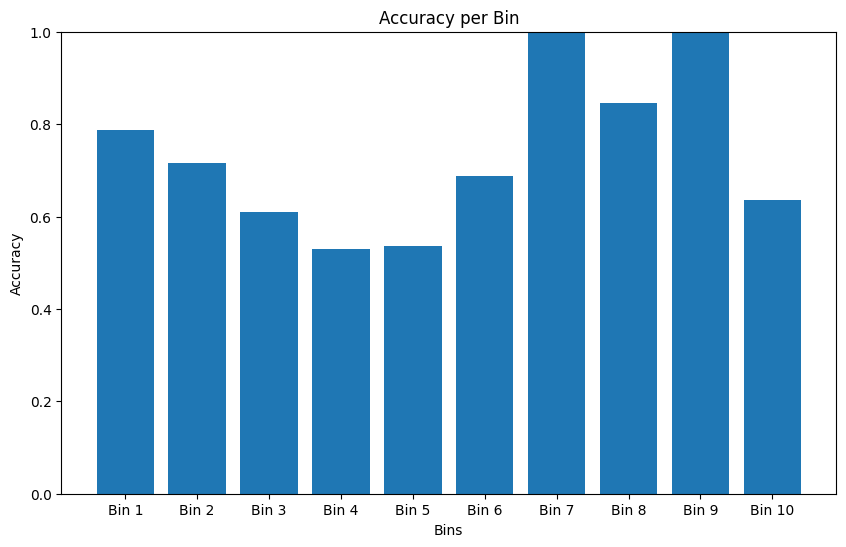

Total Accuracy: 0.7160533271370066
[0.7864232251536389, 0.7150366908100522, 0.6101178726524167, 0.5297635226963849, 0.5371669004207573, 0.6884057971014492, 1.0, 0.8461538461538461, 1.0, 0.6363636363636364]


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Define the number of bins
num_bins = 10

# Initialize lists to store AUC scores for each bin
auc_scores_per_bin = [[] for _ in range(num_bins)]

# Initialize lists to store true positive (TP), true negative (TN), false positive (FP), and false negative (FN) counts for each bin
TP_counts_per_bin = [0] * num_bins
TN_counts_per_bin = [0] * num_bins
FP_counts_per_bin = [0] * num_bins
FN_counts_per_bin = [0] * num_bins

# Cross-validation loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(features, labels)):
    # Split data into train and test sets for the current fold
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Add an extra dimension to target labels
    train_labels = train_labels.unsqueeze(1)
    test_labels = test_labels.unsqueeze(1)

    # Convert train and test data to PyTorch tensors
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    # Create DataLoaders for train and test data
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model for each fold
    input_size = train_features.shape[1]  # Assuming input size is the number of features
    hidden_size1 = 64  # Adjust as needed
    hidden_size2 = 32  # Adjust as needed
    model = LSTMModel(input_size, hidden_size1, hidden_size2)

    # Define the loss function (Binary Cross-Entropy) and optimizer (Adam)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop for each epoch
    for epoch in range(10):
        # Set the model to training mode
        model.train()

        # Iterate over the training data in batches
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()


    # Set the model to evaluation mode
    model.eval()
    test_outputs = []

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())

    # Calculate AUC score for the fold
    auc = roc_auc_score(test_labels, np.array(test_outputs))

    # Determine the bin for the current test data
    bin_indices = pd.cut(df.iloc[test_index]['smiles_length'], bins=num_bins, labels=False)

    # Store the AUC score in the respective bin's list
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        auc_scores_per_bin[i].append(auc_scores_per_bin[i] + [auc] if bin_mask.any() else [])

    # Apply threshold for binary classification
    threshold = 0.5

    # Compare predictions to true labels and update TP, TN, FP, FN counts for each bin
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        bin_predictions = (np.array(test_outputs)[bin_mask] > threshold).astype(int)
        bin_true_labels = np.array(test_labels)[bin_mask].squeeze()

        TP = np.sum((bin_predictions == 1) & (bin_true_labels == 1))
        TN = np.sum((bin_predictions == 0) & (bin_true_labels == 0))
        FP = np.sum((bin_predictions == 1) & (bin_true_labels == 0))
        FN = np.sum((bin_predictions == 0) & (bin_true_labels == 1))

        TP_counts_per_bin[i] += TP
        TN_counts_per_bin[i] += TN
        FP_counts_per_bin[i] += FP
        FN_counts_per_bin[i] += FN

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)

import matplotlib.pyplot as plt

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)

# Plot accuracy for each bin
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_bins+1), accuracy_per_bin, tick_label=[f'Bin {i+1}' for i in range(num_bins)])
plt.xlabel('Bins')
plt.ylabel('Accuracy')
plt.title('Accuracy per Bin')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1 for accuracy
plt.show()


# Calculate total TP, TN, FP, and FN counts
total_TP = sum(TP_counts_per_bin)
total_TN = sum(TN_counts_per_bin)
total_FP = sum(FP_counts_per_bin)
total_FN = sum(FN_counts_per_bin)

# Calculate total accuracy
total_samples = total_TP + total_TN + total_FP + total_FN
total_accuracy = (total_TP + total_TN) / total_samples

print("Total Accuracy:", total_accuracy)
print(accuracy_per_bin)

3. bilstm bins


<ipython-input-73-605f49b567b2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_tensor = torch.tensor(features, dtype=torch.float32)
<ipython-input-73-605f49b567b2>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels, dtype=torch.float32)
Folds: 5it [02:21, 28.29s/it]


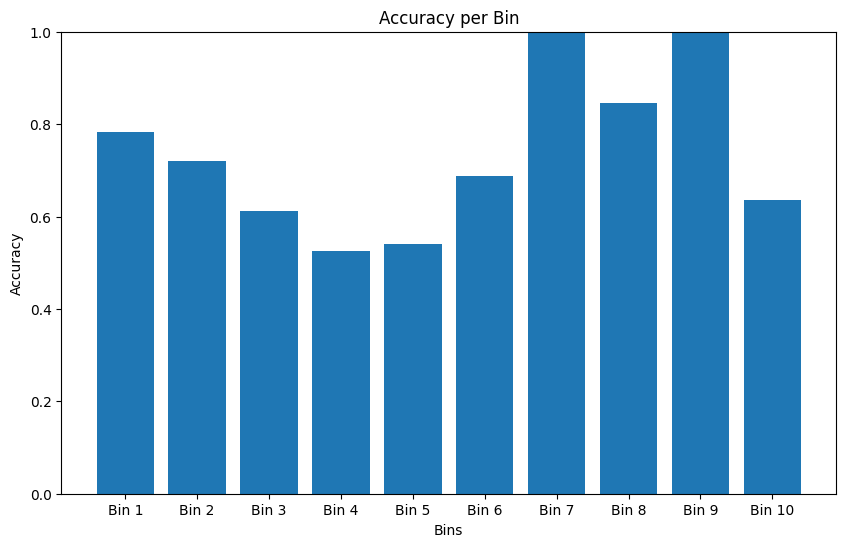

Total Accuracy: 0.7179
[0.7825394699641385, 0.7194728892377589, 0.6111612430206982, 0.5254145148138081, 0.5399719495091164, 0.6884057971014492, 1.0, 0.8461538461538461, 1.0, 0.6363636363636364]


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants
NUM_BINS = 10
N_SPLITS = 5
BATCH_SIZE = 64
N_EPOCHS = 10
THRESHOLD = 0.5
RANDOM_STATE = 42
LEARNING_RATE = 0.001
HIDDEN_SIZE1 = 64
HIDDEN_SIZE2 = 32

# Initialize metrics storage
auc_scores_per_bin = [[] for _ in range(NUM_BINS)]
TP_counts_per_bin = [0] * NUM_BINS
TN_counts_per_bin = [0] * NUM_BINS
FP_counts_per_bin = [0] * NUM_BINS
FN_counts_per_bin = [0] * NUM_BINS

# Cross-validation setup
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Convert features and labels to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

for fold, (train_idx, test_idx) in enumerate(tqdm(kfold.split(features_tensor, labels_tensor), desc="Folds")):
    # Data preparation
    train_features, test_features = features_tensor[train_idx], features_tensor[test_idx]
    train_labels, test_labels = labels_tensor[train_idx], labels_tensor[test_idx]
    train_labels, test_labels = train_labels.unsqueeze(1), test_labels.unsqueeze(1)

    # Datasets and loaders
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Model initialization
    model = LSTMModel(train_features.shape[1], HIDDEN_SIZE1, HIDDEN_SIZE2)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    for epoch in range(N_EPOCHS):
        model.train()
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_features)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()

    # Model evaluation
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_predictions = model(batch_features)
            test_predictions.extend(batch_predictions.numpy())

    # Metrics calculation
    auc_score = roc_auc_score(test_labels, np.array(test_predictions))
    bin_indices = pd.cut(df.iloc[test_idx]['smiles_length'], bins=NUM_BINS, labels=False)

    for bin_idx in range(NUM_BINS):
        bin_mask = (bin_indices == bin_idx)
        if bin_mask.any():
            auc_scores_per_bin[bin_idx].append(auc_score)

    # TP, TN, FP, FN counts
    for bin_idx in range(NUM_BINS):
        bin_mask = (bin_indices == bin_idx)
        bin_predictions = (np.array(test_predictions)[bin_mask] > THRESHOLD).astype(int)
        bin_labels = np.array(test_labels)[bin_mask].squeeze()

        TP = np.sum((bin_predictions == 1) & (bin_labels == 1))
        TN = np.sum((bin_predictions == 0) & (bin_labels == 0))
        FP = np.sum((bin_predictions == 1) & (bin_labels == 0))
        FN = np.sum((bin_predictions == 0) & (bin_labels == 1))

        TP_counts_per_bin[bin_idx] += TP
        TN_counts_per_bin[bin_idx] += TN
        FP_counts_per_bin[bin_idx] += FP
        FN_counts_per_bin[bin_idx] += FN

# Calculate and plot accuracy per bin
plt.figure(figsize=(10, 6))
accuracy_per_bin = []
for bin_idx in range(NUM_BINS):
    total = TP_counts_per_bin[bin_idx] + TN_counts_per_bin[bin_idx] + FP_counts_per_bin[bin_idx] + FN_counts_per_bin[bin_idx]
    accuracy = (TP_counts_per_bin[bin_idx] + TN_counts_per_bin[bin_idx]) / total if total > 0 else 0
    accuracy_per_bin.append(accuracy)

plt.bar(range(1, NUM_BINS + 1), accuracy_per_bin, tick_label=[f'Bin {i + 1}' for i in range(NUM_BINS)])
plt.xlabel('Bins')
plt.ylabel('Accuracy')
plt.title('Accuracy per Bin')
plt.ylim(0, 1)
plt.show()

# Total accuracy calculation
total_TP = sum(TP_counts_per_bin)
total_TN = sum(TN_counts_per_bin)
total_FP = sum(FP_counts_per_bin)
total_FN = sum(FN_counts_per_bin)
total_samples = total_TP + total_TN + total_FP + total_FN
total_accuracy = (total_TP + total_TN) / total_samples if total_samples > 0 else 0

print(f"Total Accuracy: {total_accuracy:.4f}")
print(accuracy_per_bin)

LSTM is more successful in data with shorter lengths or equally primary bins. in last bins, there is no significant difference between lstm and fc. Probably, it is due to memory in lstm structure; For long data, lstm starts to forget first characters and can not get high accuracy. It is worth mentioning that accuracy measure is sufficient so did not analysis other measures like auc. In addition, when we replaced lstm with bilstm, the accuracy for long smiles improved a little bit. Unlike lstm, bilstm is able to capture information from the future; So in long data it can predicts better that lstm.